## Speed as Rhythm

### Regressions


In [38]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import kurtosis
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats import wilcoxon
from scipy.stats import iqr
from scipy.stats import spearmanr
from scipy import stats
from scipy.stats import ttest_rel

sns.set(style="darkgrid")


In [39]:
def categorize_angles_into_quadrants(df, angle_column='angle_degrees', quadrant_column='quadrant'):
    """
    Transforms angles in degrees into quadrants (I, II, III, IV) and adds a 
    new column with the quadrant information to the DataFrame.

    Args:
        df: Pandas DataFrame containing an angle column.
        angle_column: Name of the column containing angles in degrees.  Defaults to 'angle_degrees'.
        quadrant_column: Name of the new column to store quadrant information. Defaults to 'quadrant'.

    Returns:
        Pandas DataFrame with the added quadrant column.  Returns the original DataFrame if the angle column is not found.
        Prints an error message if the angle column is not found.
    """

    if angle_column not in df.columns:
        print(f"Error: Angle column '{angle_column}' not found in DataFrame.")
        return df

    df[quadrant_column] = np.nan  # Initialize with NaN (for consistency with NaN angles)

    # Handle NaN angles directly
    nan_mask = df[angle_column].isna()

    # Vectorized operations for non-NaN angles
    valid_mask = ~nan_mask  # Invert the NaN mask

    angles = df.loc[valid_mask, angle_column].astype(float) % 360  # Vectorized modulo

    df.loc[valid_mask & (angles < 45), quadrant_column] = 'Ia'
    df.loc[valid_mask & (angles >= 45) & (angles < 90), quadrant_column] = 'Ib'
    df.loc[valid_mask & (angles >= 90) & (angles < 135), quadrant_column] = 'IIa'
    df.loc[valid_mask & (angles >= 135) & (angles < 180), quadrant_column] = 'IIb'
    df.loc[valid_mask & (angles >= 180) & (angles < 225), quadrant_column] = 'IIIa'
    df.loc[valid_mask & (angles >= 225) & (angles < 270), quadrant_column] = 'IIIb'
    df.loc[valid_mask & (angles >= 270) & (angles < 315 ), quadrant_column] = 'IVa'
    df.loc[valid_mask & (angles >= 315), quadrant_column] = 'IVb'


    return df

In [40]:
def detect_flips(df, quadrant1_col, quadrant2_col, flip_col='flip_type'):
    """
    Detects horizontal, vertical, and double flips based on quadrant changes.

    Args:
        df: Pandas DataFrame containing two quadrant columns.
        quadrant1_col: Name of the first quadrant column.
        quadrant2_col: Name of the second quadrant column.
        flip_col: Name of the new column to store flip information. Defaults to 'flip_type'.

    Returns:
        Pandas DataFrame with the added flip_type column.  Returns original DataFrame if columns are not found.
        Prints error messages if columns are not found.
    """
    
    if quadrant1_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant1_col}' not found in DataFrame.")
        return df

    if quadrant2_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant2_col}' not found in DataFrame.")
        return df

    df[flip_col] = 'N'  # Initialize

    # Create boolean masks for each flip type (vectorized)
    h_mask = ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIIb')) | \
             ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIIb'))

    v_mask = ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IIIb')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IIIb')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IIb'))

    b_mask = ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIIVb')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIb'))

    same_mask = df[quadrant1_col] == df[quadrant2_col]

    nan_mask = df[quadrant1_col].isna() | df[quadrant2_col].isna()

    # Apply masks (vectorized)
    df.loc[h_mask, flip_col] = 'H'
    df.loc[v_mask, flip_col] = 'V'
    df.loc[b_mask, flip_col] = 'B'
    df.loc[same_mask, flip_col] = 'N' # No flip if same
    df.loc[nan_mask, flip_col] = np.nan # NaN if any is NaN

    return df

# Task a
Read all participants' data for task **a**. Add a column with participant number.

In [41]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_a*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [42]:
# rename the columns
df.columns = ['trial', 'soundSpeed', 'soundAngle', 'movSpeed', 'movAngle', 'soundStart', 'startDragTime', 'endDragTime', 'hInterval', 'vInterval', 'nPart']

In [43]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='soundAngle', quadrant_column='soundQuadrant');
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
detect_flips(df, 'soundQuadrant', 'movQuadrant', 'flip')
df['speed_diff'] = df['soundSpeed'] - df['movSpeed']
df['angle_diff'] = df['soundAngle'] - df['movAngle']
# change sign of difference in quadrants II and IV, so that
# the sign of difference indicates if error is towards
# horizontal or towards vertical axes
condition = df['soundQuadrant'].isin({'IIa', 'IIb', 'IVa', 'IVb'})
df.loc[condition, 'angle_diff'] = -df.loc[condition, 'angle_diff']
display(df)
dfExpA = df
groupA_secondo = df[df['nPart'] % 2 == 0]
groupA_primo = df[df['nPart'] % 2 != 0]

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip,speed_diff,angle_diff
19,19,37.684478,304.816029,15.552421,335.947471,1740393556366,1740393576186,1740393588649,1394.330718,969.663711,1,IVa,IVb,N,22.132057,31.131442
24,24,28.267477,317.873231,27.334524,319.398705,1740393650899,1740393658815,1740393665898,1430.961216,1582.189494,1,IVb,IVb,N,0.932953,1.525474
25,25,33.835866,126.027625,41.138586,168.690068,1740393670399,1740393680921,1740393685631,1507.430202,1096.322995,1,IIa,IIb,N,-7.302720,42.662443
26,26,72.207546,143.044079,60.287944,142.774601,1740393690131,1740393694073,1740393697281,519.922342,691.065773,1,IIb,IIb,N,11.919603,-0.269479
27,27,30.696642,218.376044,52.092136,230.460213,1740393701782,1740393706405,1740393710114,1246.637830,1574.217141,1,IIIa,IIIb,N,-21.395493,-12.084168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,IIb,IIb,N,-11.006012,18.371853
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IVa,IVa,N,-13.694449,-13.899702
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,Ib,Ib,N,11.281438,-4.055355
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IVa,IVa,N,-82.618633,-7.430853


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 


In [44]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


means = 
flip
B     0.1
H     0.2
N    38.1
V     1.6
dtype: float64
std = 
flip
B    0.307794
H    0.523148
N    1.447321
V    1.231174
dtype: float64


In [45]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 38


In [46]:
dfN.tail()
# dfN.to_csv('interpret.csv')  

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip,speed_diff,angle_diff
14,14,94.444180,77.813256,76.405201,84.699073,1741191813808,1741191817440,1741191819990,1504.736993,324.971254,20,Ib,Ib,N,18.038979,-6.885817
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,IIb,IIb,N,-11.006012,18.371853
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IVa,IVa,N,-13.694449,-13.899702
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,Ib,Ib,N,11.281438,-4.055355
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IVa,IVa,N,-82.618633,-7.430853


In [47]:
print(np.mean(dfN.speed_diff))
print(np.std(dfN.speed_diff))
print(np.quantile(dfN.speed_diff, [0,0.25,0.5,0.75,1]))
print(iqr(dfN.speed_diff))

-12.955674264514284
39.36857503629376
[-471.13854769  -25.1275922    -9.98518953    5.23863187   93.12248043]
30.36622407083801


### Regression analysis for speed error
Mixed-effects model analysis, where the speed error (difference of soundSpeed and movSpeed) is the dependent variable, deviation of soundAngle from the closest diagonal angle is the independent variable, and participant (nPart) is a random effect. Give an overall population-level regression line while acknowledging that each participant has their own specific set of stimuli.

/var/folders/8p/74zcjkbs0rl_h2w_pb66g2br0000gn/T/ipykernel_4499/2484555667.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfN['diagonal_deviation'] = dfN['soundAngle'].apply(lambda x: min(abs(x - angle) for angle in diagonal_angles))
/var/folders/8p/74zcjkbs0rl_h2w_pb66g2br0000gn/T/ipykernel_4499/2484555667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfN.dropna(subset=['speed_diff', 'diagonal_deviation', 'nPart'], inplace=True)


--- Mixed-Effects Model Results ---
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   speed_diff
No. Observations:     762       Method:               REML      
No. Groups:           20        Scale:                1403.1338 
Min. group size:      34        Log-Likelihood:       -3856.3406
Max. group size:      40        Converged:            Yes       
Mean group size:      38.1                                      
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          -17.718    3.674 -4.822 0.000 -24.920 -10.516
diagonal_deviation   0.317    0.139  2.277 0.023   0.044   0.589
Group Var          149.104    1.631                             

-----------------------------------


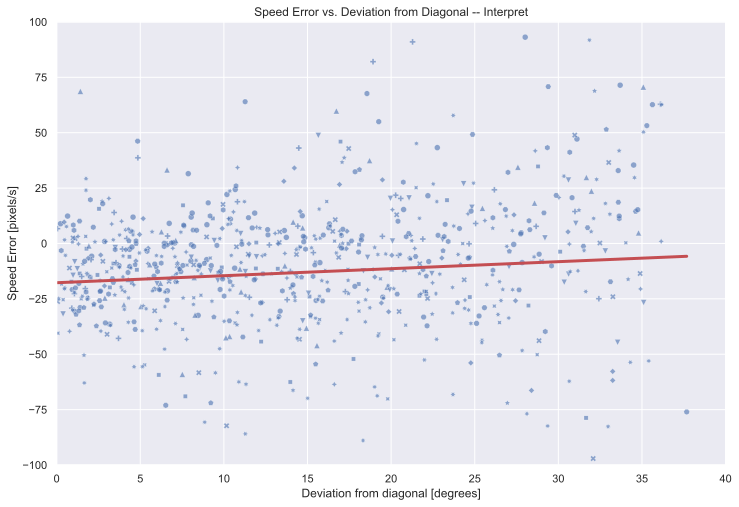

In [48]:
# Define the diagonal angles
diagonal_angles = [45, 135, 225, 315]

# Calculate the independent variable: deviation from the closest diagonal angle
# For each soundAngle, find the minimum absolute difference to any of the diagonal angles.
dfN['diagonal_deviation'] = dfN['soundAngle'].apply(lambda x: min(abs(x - angle) for angle in diagonal_angles))

# Drop rows with missing values in the relevant columns to ensure model fitting
dfN.dropna(subset=['speed_diff', 'diagonal_deviation', 'nPart'], inplace=True)

# Fit the mixed-effects model
# We specify 'speed_diff' as the dependent variable, 'diagonal_deviation' as the independent variable,
# and 'nPart' as the random effect (grouping factor).
model = smf.mixedlm("speed_diff ~ diagonal_deviation", dfN, groups=dfN["nPart"])
result = model.fit()

# Print the model summary to display the statistical results
print("--- Mixed-Effects Model Results ---")
print(result.summary())
print("-----------------------------------")

# Create a visualization of the model
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_ylim(-100, 100)
ax.set_xlim(0, 40)

# Create a scatter plot of the data points, symbol by participant
sns.scatterplot(data=dfN, x='diagonal_deviation', y='speed_diff', alpha=0.6, style='nPart',legend=False)

# Retrieve the fixed-effect estimates (the population-level intercept and slope)
intercept = result.params['Intercept']
slope = result.params['diagonal_deviation']

# Generate points for the population-level regression line
x_vals = np.linspace(dfN['diagonal_deviation'].min(), dfN['diagonal_deviation'].max(), 100)
y_vals = intercept + slope * x_vals

# Plot the population-level regression line
plt.plot(x_vals, y_vals, 'r-', linewidth=3, label='Population-level Regression')

# Add descriptive labels and a title to the plot
plt.title('Speed Error vs. Deviation from Diagonal -- Interpret')
plt.xlabel('Deviation from diagonal [degrees]')
plt.ylabel('Speed Error [pixels/s]')
# plt.legend(title='Participant (nPart)')
plt.grid(True)

# Save the plot to a file
plt.savefig("speedErrorInterpret_mixed.pdf", format="pdf", bbox_inches="tight")


### Interpretation of statistical output
1. Model Specifications

    Model: MixedLM: This indicates a Mixed Linear Model, which is appropriate for data that has both fixed effects (the variables we are explicitly testing, like diagonal_deviation) and random effects (sources of random variation, like the participants).

    Method: REML: The model is fit using Restricted Maximum Likelihood. This method provides more accurate (unbiased) estimates for the variance components of the model (i.e., the random effects) compared to standard maximum likelihood.

    No. Observations: 762: The analysis was performed on a total of 762 data points (trials) after removing any rows with missing data.

    No. Groups: 20: There are 20 distinct groups in our random effect, which corresponds to the 20 participants (nPart) in the study.
    

2. Fixed Effects: The Population-Level Trend

    The fixed effects represent the average trend across all participants.

    Intercept:

        Coefficient (Coef.): -17.718: This is the predicted value of the speedError when the independent variable, diagonal_deviation, is zero. In practical terms, this means that when a sound is played from a perfect diagonal angle, its speed is perceived to be, on average, 17.72 units slower than the actual speed of the movement.

        Significance (P>|z|): 0.000: The p-value is less than 0.001, which is highly statistically significant. This tells us that the negative speed error at diagonal angles is not due to random chance. We can be very confident that there is a genuine perceptual effect of underestimating speed for diagonal sounds.

        Confidence Interval ([0.025 0.975]): [-24.920, -10.516]: This means we are 95% confident that the true average speed error for perfect diagonal sounds in the wider population lies between -24.92 and -10.52.

    diagonal_deviation:

        Coefficient (Coef.): 0.317: This is the slope of the regression line. It indicates that for every one-degree increase in deviation from a diagonal angle, the speedError is predicted to increase by 0.317 units. Since the error is negative (an underestimation), a positive coefficient means the error becomes less negative (i.e., the underestimation gets smaller) as the angle moves away from the diagonal.

        Significance (P>|z|): 0.023: This p-value is less than the conventional alpha level of 0.05. This allows us to conclude that there is a statistically significant relationship between the deviation from a diagonal angle and the perceived speed error.

        Confidence Interval ([0.025 0.975]): [0.044, 0.589]: We are 95% confident that the true slope of this relationship in the population is between 0.044 and 0.589. Since this interval does not contain zero, it reinforces the conclusion that the effect is statistically significant.

3. Random Effects: Participant-Level Variation

    Group Var: 149.104: This term represents the variance of the random intercepts across the 20 participants. A value of zero would imply that every participant has the exact same baseline speed perception. The substantial value here indicates that there are significant individual differences between participants in their overall tendency to underestimate speed. This mathematically justifies the use of a mixed-effects model and acknowledges that while there is a general population trend, each individual has their own perceptual bias.

### Regression analysis for angle error
Mixed-effects model analysis, where the angle error (difference of soundAngle and movAngle) is the dependent variable, deviation of soundAngle from the closest diagonal angle is the independent variable, and participant (nPart) is a random effect. Give an overall population-level regression line while acknowledging that each participant has their own specific set of stimuli. The angle error is positive if the response is tilted toward the horizontal axis, negative if the response is tilted toward the vertical axis.

--- Mixed-Effects Model Results ---
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  angle_diff
No. Observations:    762      Method:              REML      
No. Groups:          20       Scale:               157.7667  
Min. group size:     34       Log-Likelihood:      -3022.3284
Max. group size:     40       Converged:           Yes       
Mean group size:     38.1                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           2.212    1.090  2.029 0.042  0.075  4.349
diagonal_deviation -0.065    0.047 -1.385 0.166 -0.156  0.027
Group Var          10.197    0.376                           

-----------------------------------


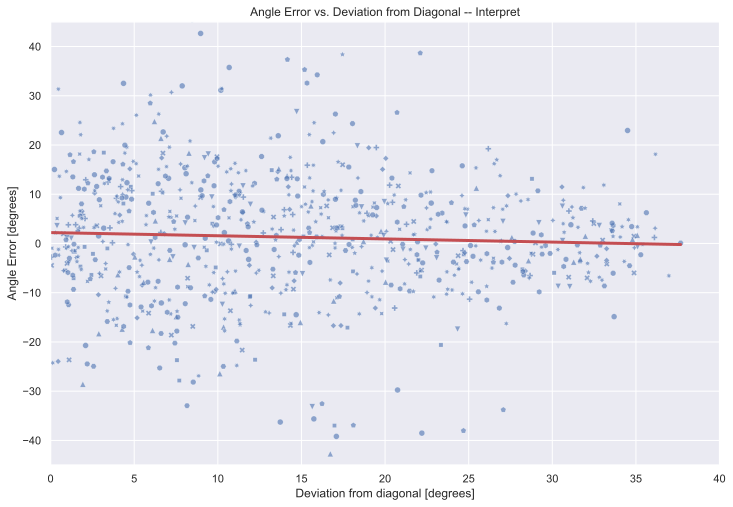

In [49]:
# Fit the mixed-effects model
# We specify 'angle_diff' as the dependent variable, 'diagonal_deviation' as the independent variable,
# and 'nPart' as the random effect (grouping factor).
model = smf.mixedlm("angle_diff ~ diagonal_deviation", dfN, groups=dfN["nPart"])
result = model.fit()

# Print the model summary to display the statistical results
print("--- Mixed-Effects Model Results ---")
print(result.summary())
print("-----------------------------------")

# Create a visualization of the model
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_ylim(-45, 45)
ax.set_xlim(0, 40)

# Create a scatter plot of the data points, symbol by participant
sns.scatterplot(data=dfN, x='diagonal_deviation', y='angle_diff', alpha=0.6, style='nPart',legend=False)

# Retrieve the fixed-effect estimates (the population-level intercept and slope)
intercept = result.params['Intercept']
slope = result.params['diagonal_deviation']

# Generate points for the population-level regression line
x_vals = np.linspace(dfN['diagonal_deviation'].min(), dfN['diagonal_deviation'].max(), 100)
y_vals = intercept + slope * x_vals

# Plot the population-level regression line
plt.plot(x_vals, y_vals, 'r-', linewidth=3, label='Population-level Regression')

# Add descriptive labels and a title to the plot
plt.title('Angle Error vs. Deviation from Diagonal -- Interpret')
plt.xlabel('Deviation from diagonal [degrees]')
plt.ylabel('Angle Error [degrees]')
# plt.legend(title='Participant (nPart)')
plt.grid(True)

# Save the plot to a file
plt.savefig("angleErrorInterpret_mixed.pdf", format="pdf", bbox_inches="tight")


# Task b
Read all participants' data for task **b**. Add a column with participant number.

In [50]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_b*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [51]:
# rename the columns
df.columns = ['trial', 'movSpeed', 'movAngle', 'tapSpeed', 'tapAngle', 'movStart', 'tapHor', 'tapVer', 'tapHor2', 'tapVer2', 'hInterval', 'vInterval', 'nPart']

In [53]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
categorize_angles_into_quadrants(df, angle_column='tapAngle', quadrant_column='tapQuadrant');
detect_flips(df, 'movQuadrant', 'tapQuadrant', 'flip')
df['speed_diff'] = df['movSpeed'] - df['tapSpeed']
df['angle_diff'] = df['movAngle'] - df['tapAngle']
# change sign of difference in quadrants II and IV, so that
# the sign of difference indicates if error is towards
# horizontal or towards vertical axes
condition = df['movQuadrant'].isin({'IIa', 'IIb', 'IVa', 'IVb'})
df.loc[condition, 'angle_diff'] = -df.loc[condition, 'angle_diff']
display(df)
dfExpB = df
groupB_secondo = df[df['nPart'] % 2 != 0]
groupB_primo = df[df['nPart'] % 2 == 0]

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip,speed_diff,angle_diff
38,38,29.069538,139.792341,18.510638,148.937093,1740394576071,1740394590426,1740394584867,1740394592318,1740394588008,1351.309406,1598.625247,1,IIb,IIb,N,10.558899,9.144751
15,15,47.295864,154.388125,30.871862,127.869972,1740394327691,1740394330588,1740394334477,1740394332171,1740394335708,703.421001,1467.372329,1,IIb,IIa,N,16.424002,-26.518153
14,14,31.558088,134.454512,36.150549,133.707467,1740394315892,1740394322676,1740394319730,1740394323877,1740394320878,1357.375186,1331.772242,1,IIa,IIa,N,-4.592461,-0.747046
13,13,77.480473,342.555969,67.151947,340.139432,1740394306524,1740394308565,1740394310764,1740394309040,1740394312079,405.859724,1291.620691,1,IVb,IVb,N,10.328526,-2.416537
12,12,32.529874,42.008159,26.163425,44.258234,1740394295225,1740394301120,1740394298062,1740394302721,1740394299705,1241.140979,1378.032018,1,Ia,Ia,N,6.366448,-2.250075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,Ib,Ib,N,28.878791,12.505811
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,IIb,IIb,N,22.154986,-0.821231
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IVb,IVb,N,9.390451,19.308251
9,9,92.749237,200.641512,36.119262,148.705422,1741191122743,1741191133175,1741191130539,1741191134147,1741191132138,345.641464,917.545167,20,IIIa,IIb,V,56.629976,51.936090


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 


In [54]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


means = 
flip
H     0.1
N    39.5
V     0.4
dtype: float64
std = 
flip
H    0.307794
N    0.827170
V    0.680557
dtype: float64


In [55]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 10


In [56]:
dfN.tail()
# dfN.to_csv('perform.csv')  

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip,speed_diff,angle_diff
13,13,64.367225,207.666240,34.939732,214.189027,1741191175307,1741191181820,1741191178495,1741191182858,1741191180023,526.242386,1003.780659,20,IIIa,IIIa,N,29.427493,-6.522787
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,Ib,Ib,N,28.878791,12.505811
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,IIb,IIb,N,22.154986,-0.821231
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IVb,IVb,N,9.390451,19.308251
39,39,56.230280,236.645440,43.161428,231.189298,1741191483474,1741191494304,1741191489578,1741191495413,1741191490470,970.357306,638.729173,20,IIIb,IIIb,N,13.068853,5.456142


In [57]:
print(np.mean(dfN.angle_diff))
print(np.std(dfN.angle_diff))
print(np.quantile(dfN.angle_diff, [0,0.25,0.5,0.75,1]))
print(iqr(dfN.angle_diff))

0.6663207344217356
12.55720306294089
[-52.68795196  -7.03881869  -0.07626175   7.96138181  54.57127197]
15.000200499220455


/var/folders/8p/74zcjkbs0rl_h2w_pb66g2br0000gn/T/ipykernel_4499/3682599981.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfN['diagonal_deviation'] = dfN['movAngle'].apply(lambda x: min(abs(x - angle) for angle in diagonal_angles))
/var/folders/8p/74zcjkbs0rl_h2w_pb66g2br0000gn/T/ipykernel_4499/3682599981.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfN.dropna(subset=['speed_diff', 'diagonal_deviation', 'nPart'], inplace=True)


--- Mixed-Effects Model Results ---
           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  speed_diff
No. Observations:   790      Method:              REML      
No. Groups:         20       Scale:               599.1392  
Min. group size:    37       Log-Likelihood:      -3659.8503
Max. group size:    40       Converged:           Yes       
Mean group size:    39.5                                    
------------------------------------------------------------
                   Coef.  Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           3.210    2.158 1.488 0.137 -1.019  7.439
diagonal_deviation  0.661    0.088 7.531 0.000  0.489  0.833
Group Var          44.035    0.793                          

-----------------------------------


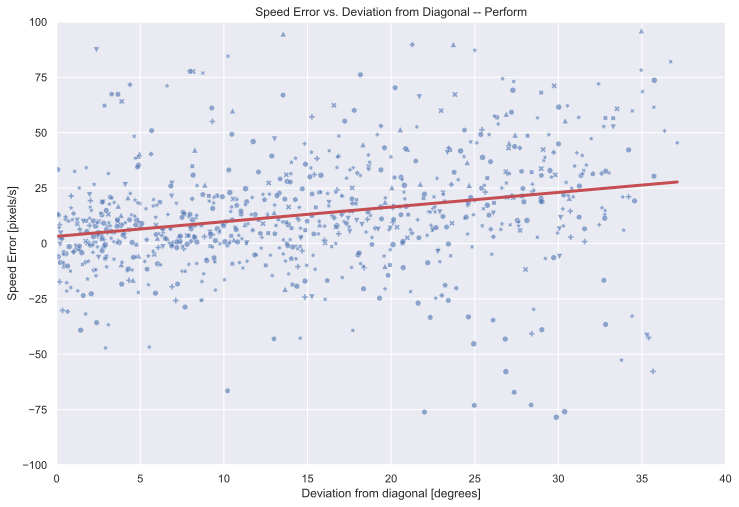

In [58]:
# Define the diagonal angles
diagonal_angles = [45, 135, 225, 315]

# Calculate the independent variable: deviation from the closest diagonal angle
# For each soundAngle, find the minimum absolute difference to any of the diagonal angles.
dfN['diagonal_deviation'] = dfN['movAngle'].apply(lambda x: min(abs(x - angle) for angle in diagonal_angles))

# Drop rows with missing values in the relevant columns to ensure model fitting
dfN.dropna(subset=['speed_diff', 'diagonal_deviation', 'nPart'], inplace=True)

# Fit the mixed-effects model
# We specify 'speedError' as the dependent variable, 'diagonal_deviation' as the independent variable,
# and 'nPart' as the random effect (grouping factor).
model = smf.mixedlm("speed_diff ~ diagonal_deviation", dfN, groups=dfN["nPart"])
result = model.fit()

# Print the model summary to display the statistical results
print("--- Mixed-Effects Model Results ---")
print(result.summary())
print("-----------------------------------")

# Create a visualization of the model
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_ylim(-100, 100)
ax.set_xlim(0, 40)

# Create a scatter plot of the data points, symbol by participant
sns.scatterplot(data=dfN, x='diagonal_deviation', y='speed_diff', alpha=0.6, style='nPart',legend=False)

# Retrieve the fixed-effect estimates (the population-level intercept and slope)
intercept = result.params['Intercept']
slope = result.params['diagonal_deviation']

# Generate points for the population-level regression line
x_vals = np.linspace(dfN['diagonal_deviation'].min(), dfN['diagonal_deviation'].max(), 100)
y_vals = intercept + slope * x_vals

# Plot the population-level regression line
plt.plot(x_vals, y_vals, 'r-', linewidth=3, label='Population-level Regression')

# Add descriptive labels and a title to the plot
plt.title('Speed Error vs. Deviation from Diagonal -- Perform')
plt.xlabel('Deviation from diagonal [degrees]')
plt.ylabel('Speed Error [pixels/s]')
# plt.legend(title='Participant (nPart)')
plt.grid(True)

# Save the plot to a file
plt.savefig("speedErrorPerform_mixed.pdf", format="pdf", bbox_inches="tight")

### Regression analysis for angle error
Mixed-effects model analysis, where the angle error (difference of soundAngle and movAngle) is the dependent variable, deviation of soundAngle from the closest diagonal angle is the independent variable, and participant (nPart) is a random effect. Give an overall population-level regression line while acknowledging that each participant has their own specific set of stimuli. The angle error is positive if the response is tilted toward the horizontal axis, negative if the response is tilted toward the vertical axis.

--- Mixed-Effects Model Results ---
            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  angle_diff
No. Observations:    790      Method:              REML      
No. Groups:          20       Scale:               151.7057  
Min. group size:     37       Log-Likelihood:      -3115.3597
Max. group size:     40       Converged:           Yes       
Mean group size:     39.5                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.695    0.978  0.710 0.478 -1.223  2.612
diagonal_deviation -0.002    0.044 -0.046 0.963 -0.089  0.084
Group Var           6.737    0.283                           

-----------------------------------


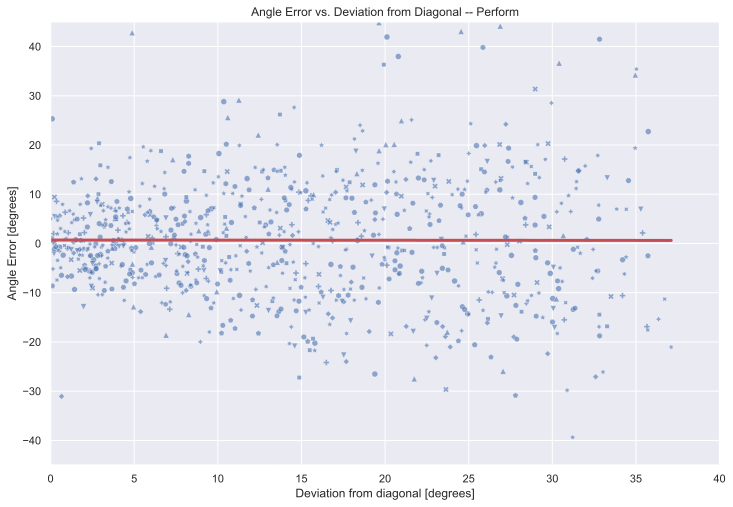

In [59]:
# Fit the mixed-effects model
# We specify 'angle_diff' as the dependent variable, 'diagonal_deviation' as the independent variable,
# and 'nPart' as the random effect (grouping factor).
model = smf.mixedlm("angle_diff ~ diagonal_deviation", dfN, groups=dfN["nPart"])
result = model.fit()

# Print the model summary to display the statistical results
print("--- Mixed-Effects Model Results ---")
print(result.summary())
print("-----------------------------------")

# Create a visualization of the model
plt.figure(figsize=(12, 8))
ax = plt.axes()
ax.set_ylim(-45, 45)
ax.set_xlim(0, 40)

# Create a scatter plot of the data points, symbol by participant
sns.scatterplot(data=dfN, x='diagonal_deviation', y='angle_diff', alpha=0.6, style='nPart',legend=False)

# Retrieve the fixed-effect estimates (the population-level intercept and slope)
intercept = result.params['Intercept']
slope = result.params['diagonal_deviation']

# Generate points for the population-level regression line
x_vals = np.linspace(dfN['diagonal_deviation'].min(), dfN['diagonal_deviation'].max(), 100)
y_vals = intercept + slope * x_vals

# Plot the population-level regression line
plt.plot(x_vals, y_vals, 'r-', linewidth=3, label='Population-level Regression')

# Add descriptive labels and a title to the plot
plt.title('Angle Error vs. Deviation from Diagonal -- Perform')
plt.xlabel('Deviation from diagonal [degrees]')
plt.ylabel('Angle Error [degrees]')
# plt.legend(title='Participant (nPart)')
plt.grid(True)

# Save the plot to a file
plt.savefig("angleErrorPerform_mixed.pdf", format="pdf", bbox_inches="tight")


In [26]:
# Asymmetric transfer learning
errAngleA_primo = groupA_primo.movAngle - groupA_primo.soundAngle
errAngleA_secondo = groupA_secondo.movAngle - groupA_secondo.soundAngle
errSpeedA_primo = groupA_primo.soundSpeed - groupA_primo.movSpeed
errSpeedA_secondo = groupA_secondo.soundSpeed - groupA_secondo.movSpeed
errAngleB_primo = groupB_primo.tapAngle - groupB_primo.movAngle
errAngleB_secondo = groupB_secondo.tapAngle - groupB_secondo.movAngle
errSpeedB_primo = groupB_primo.movSpeed - groupB_primo.tapSpeed
errSpeedB_secondo = groupB_secondo.movSpeed - groupB_secondo.tapSpeed

print("Medie:")
print(np.mean(errAngleA_primo))
print(np.mean(errAngleA_secondo))
print(np.mean(errSpeedA_primo))
print(np.mean(errSpeedA_secondo))
print(np.mean(errAngleB_primo))
print(np.mean(errAngleB_secondo))
print(np.mean(errSpeedB_primo))
print(np.mean(errSpeedB_secondo))

print("Mediane:")
print(np.median(errAngleA_primo))
print(np.median(errAngleA_secondo))
print(np.median(errSpeedA_primo))
print(np.median(errSpeedA_secondo))
print(np.median(errAngleB_primo))
print(np.median(errAngleB_secondo))
print(np.median(errSpeedB_primo))
print(np.median(errSpeedB_secondo))

print("Shapiro-Wilk test per normalità degli errori:")
print(f"Errore angolo A primo: p={shapiro(errAngleA_primo).pvalue}")
print(f"Errore angolo A secondo: p={shapiro(errAngleA_secondo).pvalue}")
print(f"Errore velocità A primo: p={shapiro(errSpeedA_primo).pvalue}")
print(f"Errore velocità A secondo: p={shapiro(errSpeedA_secondo).pvalue}")
print(f"Errore angolo B primo: p={shapiro(errAngleB_primo).pvalue}")
print(f"Errore angolo B secondo: p={shapiro(errAngleB_secondo).pvalue}")
print(f"Errore velocità B primo: p={shapiro(errSpeedB_primo).pvalue}")
print(f"Errore velocità B secondo: p={shapiro(errSpeedB_secondo).pvalue}")

# p < 0.01

# t-test for paired samples
t_stat_angolo_A, p_value_angolo_A = wilcoxon(errAngleA_primo, errAngleA_secondo)
t_stat_velocita_A, p_value_velocita_A = wilcoxon(errSpeedA_primo, errSpeedA_secondo)
t_stat_angolo_B, p_value_angolo_B = wilcoxon(errAngleB_primo, errAngleB_secondo)
t_stat_velocita_B, p_value_velocita_B = wilcoxon(errSpeedB_primo, errSpeedB_secondo)

print(f'Wilcoxon per errore angolo A: T={t_stat_angolo_A:.4f}, p={p_value_angolo_A:.4f}')
print(f'Wilcoxon per errore velocità A: T={t_stat_velocita_A:.4f}, p={p_value_velocita_A:.4f}')
print(f'Wilcoxon per errore angolo B: T={t_stat_angolo_B:.4f}, p={p_value_angolo_B:.4f}')
print(f'Wilcoxon per errore velocità B: T={t_stat_velocita_B:.4f}, p={p_value_velocita_B:.4f}')

Medie:
4.934601586004099
2.9641879815377625
-7.643284760213593
-17.526138946713782
0.6621890289926888
0.292666182147361
13.003077998936142
13.656664317623935
Mediane:
-0.30923073204934326
0.6408703109375296
-6.285734836234255
-13.55941751544037
-0.54470633802379
0.9235323231211154
9.46414217606845
10.735668210848527
Shapiro-Wilk test per normalità degli errori:
Errore angolo A primo: p=4.544579297461221e-32
Errore angolo A secondo: p=4.818572897155038e-35
Errore velocità A primo: p=2.3920581013838214e-21
Errore velocità A secondo: p=6.5609052671947684e-24
Errore angolo B primo: p=9.776075881042968e-31
Errore angolo B secondo: p=5.234484572672102e-32
Errore velocità B primo: p=7.894201559111025e-08
Errore velocità B secondo: p=3.7009957321032516e-09
Wilcoxon per errore angolo A: T=38790.0000, p=0.5713
Wilcoxon per errore velocità A: T=30555.0000, p=0.0000
Wilcoxon per errore angolo B: T=39042.0000, p=0.6475
Wilcoxon per errore velocità B: T=38137.0000, p=0.3962
